In [1]:
import sys

import pandas as pd
import geopandas as gpd
import xarray as xr
import rasterio
import rasterio.mask
from rasterio import features
from rasterstats import zonal_stats
import shapely.geometry
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import seaborn

sys.path.append('../src/construct/')
import util

idx = pd.IndexSlice

EPSG_3035_PROJ4 = "+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs "
WGS84 = "EPSG:4326"

In [2]:
def map_to_merra2(air_temp_ds, units, temperature_threshold):
    """
    Get population and heating degree day (HDD) per MERRA-2 grid cell, 
    and map those grid cells to user-defined shapes (e.g. NUTS regions)
    """
    # Constraint to extent of the user-defined shapes
    # total_bounds gives minx, miny, maxx, maxy (x -> lon, y -> lat)
    air_temp_ds = air_temp_ds.where(
        (air_temp_ds.lat <= units.total_bounds[3]) &
        (air_temp_ds.lat >= units.total_bounds[1]) &
        (air_temp_ds.lon <= units.total_bounds[2]) &
        (air_temp_ds.lon >= units.total_bounds[0])
    ).dropna('site')
    
    # Get HDD
    coords = air_temp_ds[['lat', 'lon']].to_dataframe()
    temperatures = air_temp_ds['temperature']
    annual_hdd = get_hdd(temperatures, temperature_threshold)

    # Create geodataframe of MERRA2 gridcells
    points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(coords.lon.values, coords.lat.values),
        index=coords.index, crs=WGS84
    )
    points_metres = points.to_crs(EPSG_3035_PROJ4)
    polys_metres = gpd.GeoDataFrame(
        index=points_metres.index, geometry=points_metres.buffer(25000).envelope  # 50km horizontal resolution
    )
    # Overlay user-defined shapes onto gridcells
    polys = gpd.overlay(polys_metres.to_crs(WGS84).reset_index(), units.reset_index().to_crs(WGS84))

    pop_polys_with_hdd = (
        polys.set_index('site')
        .merge(annual_hdd, left_index=True, right_index=True)
    )

    return pop_polys_with_hdd


def get_hdd(air_temp, temperature_threshold):
    average_daily_air_temp = air_temp.resample(time='1D').mean('time')
    hdd = temperature_threshold - average_daily_air_temp
    hdd = hdd.where(hdd >= 0, other=0)

    annual_hdd = hdd.groupby('time.year').sum('time').to_pandas()

    return annual_hdd

# Analysis using UK local authority gas conumption

In [3]:
gas_lau1_con = pd.read_excel(
    'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/853638/Weather_Uncorrected_Sub-national_gas_consumption_statistics_2016-2018.xlsx',
    sheet_name='2017r', header=[0, 1, 2]
)
gas_lau1_con_all = pd.to_numeric(gas_lau1_con.set_index(
    ('Sub-national weather uncorrected gas sales and numbers of customers, 2017', 'Unnamed: 3_level_1', 'LA Code')
)[('Sales (GWh)', 'Unnamed: 10_level_1', 'Total consumption')].dropna(), errors='coerce')
gas_lau1_con_all.index = gas_lau1_con_all.index.rename('LA Code')

gas_lau1_con_dom = pd.to_numeric(gas_lau1_con.set_index(
    ('Sub-national weather uncorrected gas sales and numbers of customers, 2017', 'Unnamed: 3_level_1', 'LA Code')
)[('Sales (GWh)', 'Unnamed: 8_level_1', 'Domestic consumption')].dropna(), errors='coerce')
gas_lau1_con_dom.index = gas_lau1_con_dom.index.rename('LA Code')

gas_lau1_con_nondom = pd.to_numeric(gas_lau1_con.set_index(
    ('Sub-national weather uncorrected gas sales and numbers of customers, 2017', 'Unnamed: 3_level_1', 'LA Code')
)[('Sales (GWh)', 'Unnamed: 9_level_1', 'Non-domestic consumption')].dropna(), errors='coerce')
gas_lau1_con_nondom.index = gas_lau1_con_nondom.index.rename('LA Code')

# Electricity consumption per LAU
elec_lau1_con = pd.read_excel(
    'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/853754/Sub-national_electricity_consumption_statistics_2005-2018.xlsx',
    sheet_name='2017r', header=[0, 1, 2]
)
elec_lau1_con_all = elec_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2017(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'All')].dropna()
elec_lau1_con_all.index = elec_lau1_con_all.index.rename('LA Code')

elec_lau1_con_dom = elec_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2017(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'Domestic consumers', 'All domestic')].dropna()
elec_lau1_con_dom.index = elec_lau1_con_dom.index.rename('LA Code')


elec_lau1_con_nondom = elec_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2017(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'Non-domestic consumers', 'All non-domestic')].dropna()
elec_lau1_con_nondom.index = elec_lau1_con_nondom.index.rename('LA Code')

# Shapefile of the LAU1 units
uk_lau1_units = gpd.read_file('http://geoportal1-ons.opendata.arcgis.com/datasets/1d78d47c87df4212b79fe2323aae8e08_0.geojson')  # 'http://opendata.arcgis.com/datasets/fef73aeaf13c417dadf2fc99abcf8eef_0.geojson'
uk_lau1_units = uk_lau1_units.set_index('lad19cd')[['lad19nm', 'geometry']]
uk_lau1_units.index = uk_lau1_units.index.rename('LA Code')

# Population data of LAU1 units (only used to get city boolean indicators)
lau_conversion_2018 = pd.read_excel(
    'https://ec.europa.eu/eurostat/documents/345175/501971/EU-28-LAU-2018-NUTS-2016.xlsx',
    sheet_name='UK', header=0
)
pop_2018 = lau_conversion_2018.set_index('LAU NAME NATIONAL')

pop_2018 = pop_2018.reindex(uk_lau1_units.lad19nm).set_index(uk_lau1_units.index).dropna(how='all')
gas_lau1_con_all = gas_lau1_con_all.reindex(uk_lau1_units.index).dropna(how='all')
gas_lau1_con_dom = gas_lau1_con_dom.reindex(uk_lau1_units.index).dropna(how='all')
gas_lau1_con_nondom = gas_lau1_con_nondom.reindex(uk_lau1_units.index).dropna(how='all')
elec_lau1_con_all = elec_lau1_con_all.reindex(uk_lau1_units.index).dropna(how='all')
elec_lau1_con_dom = elec_lau1_con_dom.reindex(uk_lau1_units.index).dropna(how='all')
elec_lau1_con_nondom = elec_lau1_con_nondom.reindex(uk_lau1_units.index).dropna(how='all')

uk_lau1_units = uk_lau1_units.reindex(gas_lau1_con_all.index).assign(
    city=(~pop_2018['CITY_NAME'].isnull()).astype('float'),
    gas_con_all=gas_lau1_con_all / 1000,
    gas_con_dom=gas_lau1_con_dom / 1000,
    gas_con_nondom=gas_lau1_con_nondom / 1000,
    elec_con_all=elec_lau1_con_all / 1000,
    elec_con_dom=elec_lau1_con_dom / 1000,
    elec_con_nondom=elec_lau1_con_nondom / 1000
)

/cluster/work/apatt/brynmorp/miniconda/envs/euro-spores/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2867: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


ValueError: cannot reindex from a duplicate axis

In [277]:
gpd.read_file('https://geoportal1-ons.opendata.arcgis.com/datasets/b6d2e15801de45328b760a4f55d74318_0.geojson')

HTTPError: HTTP Error 404: Not Found

,objectid,lad19cd,lad19nm,lad19nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape,geometry
0,1,E06000001,Hartlepool,,447160,531474,-1.27018,54.676140,9.371262e+07,71011.933949,"MULTIPOLYGON (((-1.26846 54.72612, -1.26858 54..."
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.544670,5.388156e+07,44481.691242,"MULTIPOLYGON (((-1.24928 54.59072, -1.24964 54..."
2,3,E06000003,Redcar and Cleveland,,464361,519597,-1.00608,54.567520,2.450695e+08,96703.989701,"MULTIPOLYGON (((-1.13485 54.64296, -1.13474 54..."
3,4,E06000004,Stockton-on-Tees,,444940,518183,-1.30664,54.556911,2.049330e+08,123408.985928,"MULTIPOLYGON (((-1.31729 54.64480, -1.31756 54..."
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.535339,1.974757e+08,107206.401677,"POLYGON ((-1.63768 54.61714, -1.63800 54.61720..."
...,...,...,...,...,...,...,...,...,...,...,...
377,378,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.698360,1.262399e+08,82544.775967,"POLYGON ((-3.10490 51.79504, -3.10498 51.79508..."
378,379,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.778271,8.502646e+08,224184.496320,"MULTIPOLYGON (((-3.05202 51.97282, -3.05215 51..."
379,380,W06000022,Newport,Casnewydd,337897,187432,-2.89769,51.582310,1.903728e+08,153723.498020,"MULTIPOLYGON (((-2.83665 51.64942, -2.83682 51..."
380,381,W06000023,Powys,Powys,302329,273255,-3.43531,52.348640,5.195312e+09,610145.541416,"POLYGON ((-3.15512 52.89799, -3.15502 52.89805..."


In [22]:
uk_lau1_units#.to_file('../data/uk_LA_units_Dec_2018.geojson', driver='GeoJSON')

,lad18nm,geometry,city,gas_con_all,gas_con_dom,gas_con_nondom,elec_con_all,elec_con_dom,elec_con_nondom
LA Code,,,,,,,,,
E06000001,Hartlepool,"MULTIPOLYGON (((-1.26846 54.72612, -1.26858 54...",1.0,0.828722,0.553381,0.275341,0.438292,0.133723,0.304569
E06000002,Middlesbrough,"MULTIPOLYGON (((-1.24390 54.58936, -1.24426 54...",1.0,1.107797,0.788258,0.319539,0.465385,0.192212,0.273174
E06000003,Redcar and Cleveland,"MULTIPOLYGON (((-1.13758 54.64581, -1.13743 54...",0.0,1.904752,0.800884,1.103868,0.801521,0.199736,0.601785
E06000004,Stockton-on-Tees,"MULTIPOLYGON (((-1.31729 54.64480, -1.31756 54...",1.0,1.918349,1.129001,0.789348,1.275543,0.277303,0.998240
E06000005,Darlington,"POLYGON ((-1.43836 54.59508, -1.43859 54.59517...",1.0,1.231947,0.657833,0.574114,0.398230,0.166101,0.232129
...,...,...,...,...,...,...,...,...,...
W06000020,Torfaen,"POLYGON ((-2.95891 51.62878, -2.95892 51.62884...",0.0,0.849529,0.505488,0.344041,0.403987,0.130151,0.273836
W06000021,Monmouthshire,"MULTIPOLYGON (((-3.05202 51.97282, -3.05215 51...",0.0,0.727309,0.412245,0.315064,0.400850,0.162477,0.238373
W06000022,Newport,"MULTIPOLYGON (((-2.83665 51.64942, -2.83682 51...",1.0,1.541811,0.784514,0.757298,0.840310,0.221536,0.618774


In [280]:
air_temp = xr.open_dataset('../data/weather/temperature.nc')
air_temp_2017 = air_temp.loc[{'time': '2017'}]
air_temp_2017['temperature'] = air_temp_2017['temperature'].where(
    (air_temp_2017['time.month'] > 9) | (air_temp_2017['time.month'] < 4), other=15.5
)

merra_mapped_data = map_to_merra2(air_temp_2017, uk_lau1_units, 14.2).set_index('LA Code', append=True)
areas = merra_mapped_data.area
_df = merra_mapped_data.groupby(level='LA Code').agg(
    weighted_hdd=(2017, lambda x: np.average(x, weights=areas.loc[x.index])),
)
uk_lau1_units = uk_lau1_units.assign(hdd=_df.loc[:, 'weighted_hdd'])

In [281]:
with rasterio.open('../land-eligibility/build/esm-class50-buildings.tif') as src:  # need to access this from older version of the workflow
    array = src.read(1)
    crs = src.crs
    affine = src.transform

    building_percentage_polys = zonal_stats(uk_lau1_units.to_crs(crs), array, affine=affine, stats='mean', nodata=np.nan)
    uk_lau1_units['building_area'] = [i['mean'] for i in building_percentage_polys]
    

with rasterio.open('../../euro-calliope/build/data/population.tif') as src:
    array = src.read(1)
    crs = src.crs
    affine = src.transform

    pop_polys = zonal_stats(uk_lau1_units.to_crs(crs), array, affine=affine, stats='sum', nodata=0)
    uk_lau1_units['population'] = [i['sum'] for i in pop_polys]

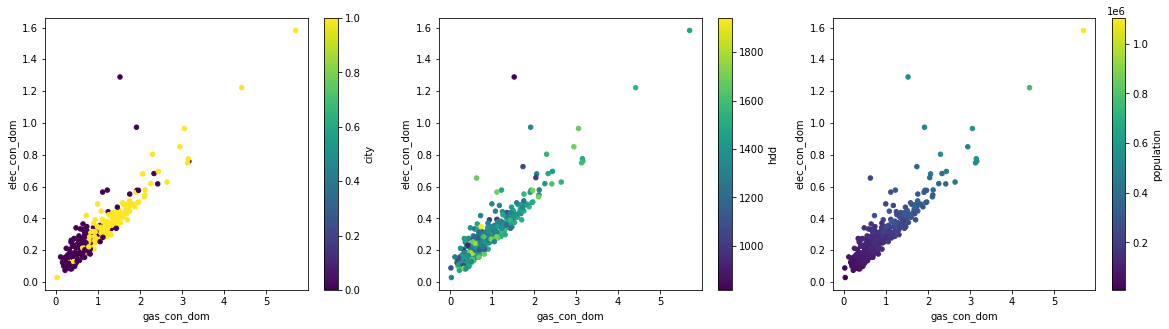

In [288]:
# As expected, gas and eletricity consumption follow each other, and LAUs containing cities have greater demand than those which don't. 
# Greatest outliers are not in cities, have low HDD and a medium population
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
pd.DataFrame(uk_lau1_units).plot.scatter(x='gas_con_dom', y='elec_con_dom', c='city', cmap='viridis', ax=ax[0])
pd.DataFrame(uk_lau1_units).plot.scatter(x='gas_con_dom', y='elec_con_dom', c='hdd', cmap='viridis', ax=ax[1])
pd.DataFrame(uk_lau1_units).plot.scatter(x='gas_con_dom', y='elec_con_dom', c='population', cmap='viridis', ax=ax[2])

In [283]:
uk_lau1_units.to_file('../data/uk_lau_consumption_data.geojson', driver='GeoJSON')

Text(0.5, 1.0, 'building_area')

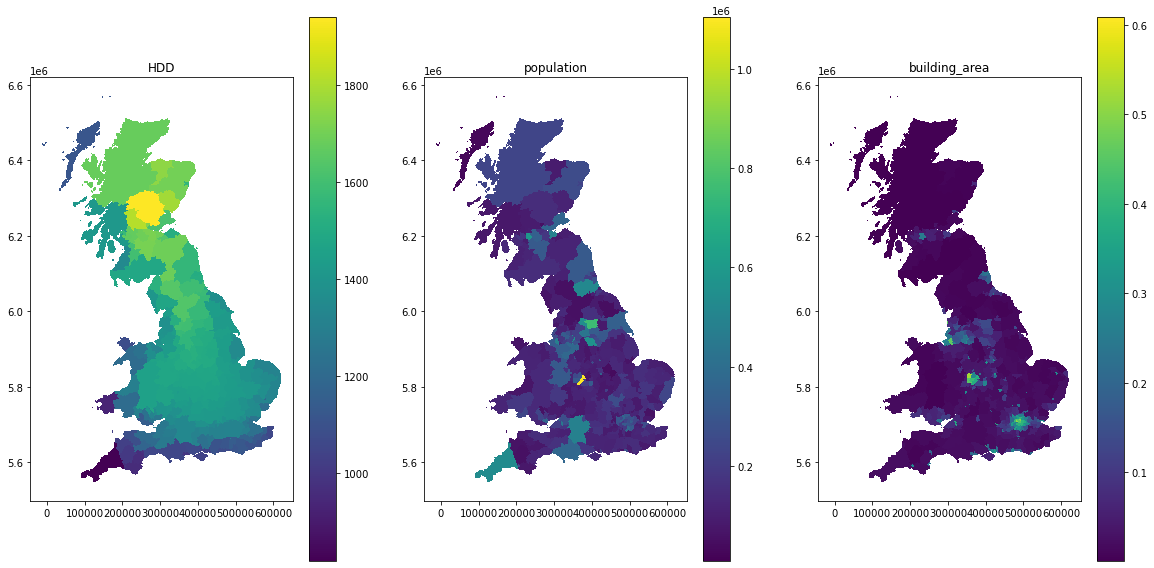

In [282]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
units_reshaped = uk_lau1_units.to_crs('EPSG:23090')
units_reshaped.plot('hdd', antialiased=False, legend=True, ax=ax[0])
units_reshaped.plot('population', antialiased=False, legend=True, ax=ax[1])
units_reshaped.plot('building_area', antialiased=False, legend=True, ax=ax[2])
ax[0].set_title('HDD')
ax[1].set_title('population')
ax[2].set_title('building_area')

In [284]:
data = uk_lau1_units.dropna().sample(frac=1)
x_train, x_test, y_train, y_test = train_test_split(data[['hdd', 'population', 'building_area']].values, data.gas_con_dom.values, test_size=0.25, random_state=23)
rand_forest_model = RandomForestRegressor(random_state=23)
rand_forest_model.fit(x_train, y_train)
y_pred = rand_forest_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'rmse: {np.sqrt(mse)}')
imp = rand_forest_model.feature_importances_

rmse: 0.16842809939612005


In [29]:
uk_lau1_units['gas_con_per_mpan_dom'] = uk_lau1_units['gas_con_dom'] / uk_lau1_units['gas_mpan_dom']

Text(0.5, 1.0, 'Feature importance in predicting domestic\ngas consumption using a random forest regressor')

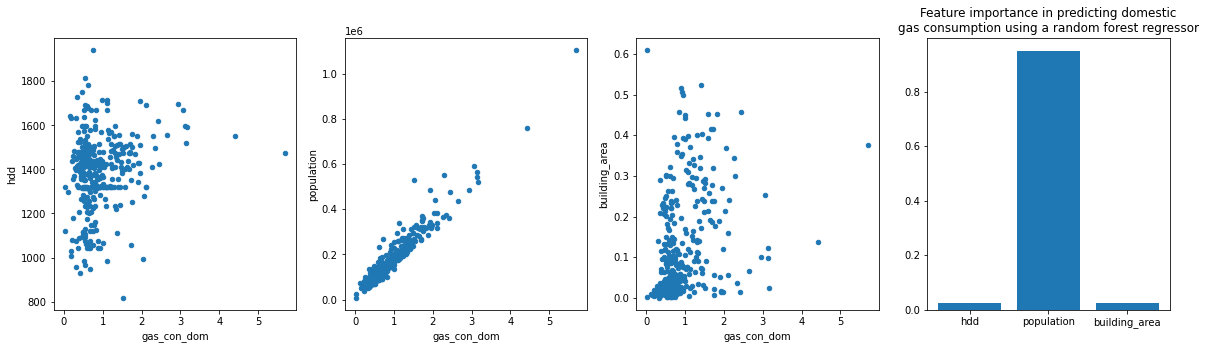

In [285]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
pd.DataFrame(uk_lau1_units).plot.scatter(x='gas_con_dom', y='hdd', ax=ax[0])
pd.DataFrame(uk_lau1_units).plot.scatter(x='gas_con_dom', y='population', ax=ax[1])
pd.DataFrame(uk_lau1_units).plot.scatter(x='gas_con_dom', y='building_area', ax=ax[2])
ax[3].bar(x=['hdd', 'population', 'building_area'], height=imp)
ax[3].set_title('Feature importance in predicting domestic\ngas consumption using a random forest regressor')

In [36]:
uk_lau1_units['pop_density'] = uk_lau1_units['population'] / uk_lau1_units.to_crs('epsg:3035').area 

rmse: 1.281146687388194e-06


Text(0.5, 1.0, 'Feature importance in predicting domestic\ngas consumption per meter using a random forest regressor')

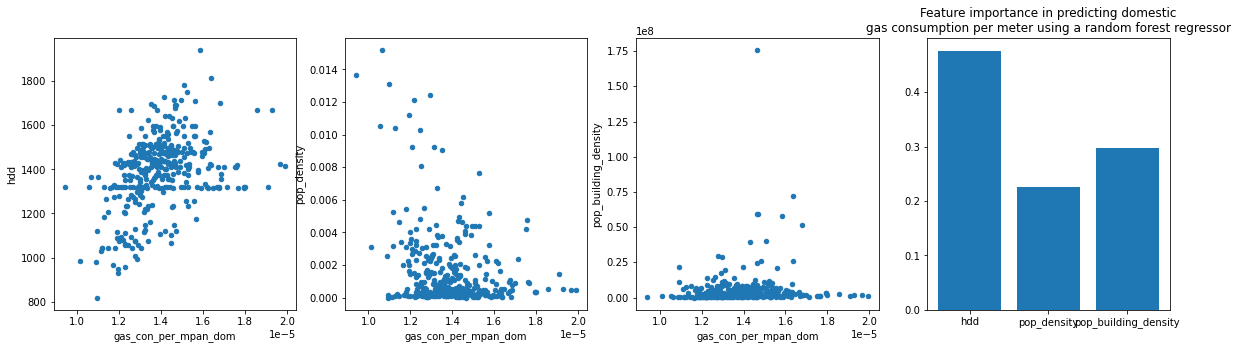

In [37]:
data = uk_lau1_units.dropna().sample(frac=1)
x_train, x_test, y_train, y_test = train_test_split(data[['hdd', 'pop_building_density', 'pop_density']].values, data.gas_con_per_mpan_dom.values, test_size=0.25, random_state=23)
rand_forest_model = RandomForestRegressor(random_state=23)
rand_forest_model.fit(x_train, y_train)
y_pred = rand_forest_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'rmse: {np.sqrt(mse)}')
imp = rand_forest_model.feature_importances_

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
pd.DataFrame(uk_lau1_units).plot.scatter(x='gas_con_per_mpan_dom', y='hdd', ax=ax[0])
pd.DataFrame(uk_lau1_units).plot.scatter(x='gas_con_per_mpan_dom', y='pop_density', ax=ax[1])
pd.DataFrame(uk_lau1_units).plot.scatter(x='gas_con_per_mpan_dom', y='pop_building_density', ax=ax[2])
ax[3].bar(x=['hdd', 'pop_density', 'pop_building_density'], height=imp)
ax[3].set_title('Feature importance in predicting domestic\ngas consumption per meter using a random forest regressor')

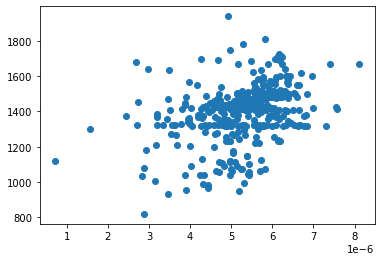

In [287]:
plt.scatter(uk_lau1_units['gas_con_dom'].div(uk_lau1_units['population']), uk_lau1_units['hdd'])

# Analysis using national heat demand across European countries

In [34]:
uk_lau1_units['gas_con_dom']

27    ALB
0     AUT
1     BEL
2     BGR
28    BIH
33    CHE
4     CYP
5     CZE
10    DEU
6     DNK
24    ESP
7     EST
8     FIN
9     FRA
26    GBR
11    GRC
3     HRV
12    HUN
13    IRL
34    ISL
14    ITA
16    LTU
17    LUX
15    LVA
29    MKD
30    MNE
18    NLD
31    NOR
19    POL
20    PRT
21    ROU
32    SRB
22    SVK
23    SVN
25    SWE
Name: country_code, dtype: object

In [38]:
# HDD calc thresholds, based on [Kozarcanin_2019]
# Comments refer to how data gaps were filled
summer_months = {
    #'ALB': [4, 10],  # GRC
    'AUT': [6, 9],
    'BEL': [5, 10],
    'BGR': [5, 10],
    'BIH': [4, 10],
    'CHE': [4, 9],
    #'CYP': [4, 11],  # GRC
    'CZE': [6, 9],
    'DEU': [6, 10],
    'DNK': [5, 10],
    'ESP': [4, 11],
    'EST': [5, 10],
    'FIN': [6, 9],
    'FRA': [6, 9],
    'GBR': [5, 10],
    'GRC': [4, 10],
    'HRV': [5, 10],
    'HUN': [5, 10],
    'IRL': [4, 11],
    'ITA': [5, 10],
    'LTU': [5, 10],
    #'LUX': [5, 10],  # BEL
    'LVA': [5, 10],
    #'MKD': [4, 10],  # GRC 
    #'MNE': [4, 10],  # BIH
    'NLD': [5, 10],
    'NOR': [6, 9],
    'POL': [6, 9],
    'PRT': [4, 11],
    'ROU': [4, 10],
    'SRB': [5, 10],
    'SVK': [5, 10],
    'SVN': [5, 10],
    'SWE': [6, 9],
}

t_thresh = {
    #'ALB': 16.8,  # GRC
    'AUT': 14.6,
    'BEL': 15.2,
    'BGR': 16.0,
    'BIH': 16.0,  # BGR
    'CHE': 14.6,  # AUT
    #'CYP': 16.8,  # GRC
    'CZE': 14.8,
    'DEU': 14.0,
    'DNK': 15.2,
    'ESP': 18.5,
    'EST': 11.1,
    'FIN': 13.2,  # Elec instead of gas threshold
    'FRA': 15.6,
    'GBR': 14.2,
    'GRC': 16.8,
    'HRV': 18.7,
    'HUN': 16.8,
    'IRL': 12.8,
    'ITA': 15.6,
    'LTU': 15.2,
    #'LUX': 14.2,  # BEL
    'LVA': 13.0,
    #'MKD': 16.8,  # GRC
    #'MNE': 16.0,  # BGR
    'NLD': 14.0,
    'NOR': 11.5,  # Elec instead of gas threshold
    'POL': 15.2,
    'PRT': 18.5,  # ESP
    'ROU': 15.4,
    'SRB': 16.8,  # GRC
    'SVK': 14.2,
    'SVN': 15.4,
    'SWE': 13.2,  # Elec instead of gas threshold
}

In [49]:
len(mapped_datas)

34

,,country_code,id,name,type,proper,building_area,population,geometry,2000,2001,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
site,index,,,,,,,,,,,,,,,,,,,,,
1141,0,AUT,AUT,Austria,country,True,0.017293,8.545747e+06,"POLYGON ((9.78523 47.03823, 10.43339 47.03760,...",4325.379395,4354.085938,...,4483.691406,4745.274414,4002.335693,4442.648926,4487.487793,3958.861084,4034.194580,4234.992676,4221.622559,4077.750732
1142,0,AUT,AUT,Austria,country,True,0.017293,8.545747e+06,"MULTIPOLYGON (((10.43651 47.41184, 10.43648 47...",3495.867920,3568.092773,...,3698.734131,3951.379883,3220.102783,3672.342041,3720.385010,3132.517822,3297.156738,3465.387695,3484.541748,3238.496826
1143,0,AUT,AUT,Austria,country,True,0.017293,8.545747e+06,"MULTIPOLYGON (((10.43797 47.58395, 10.43783 47...",2642.079346,2793.753662,...,2881.208984,3160.583008,2499.236816,2882.733398,2952.159180,2322.703613,2551.486572,2711.740967,2750.151855,2444.643799
1190,0,AUT,AUT,Austria,country,True,0.017293,8.545747e+06,"POLYGON ((10.43273 46.95677, 10.43339 47.03760...",4221.298340,4269.968262,...,4445.429199,4692.008301,3964.811035,4376.801758,4402.752930,3877.967773,3951.264648,4144.740723,4152.247070,4016.564697
1191,0,AUT,AUT,Austria,country,True,0.017293,8.545747e+06,"POLYGON ((10.43339 47.03760, 10.43625 47.38064...",3674.498779,3754.742676,...,3906.123779,4142.690430,3434.952148,3865.615234,3893.339355,3313.562744,3474.299805,3639.884033,3677.700195,3439.599854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,33,CHE,CHE,Switzerland,country,True,0.025972,8.255436e+06,"MULTIPOLYGON (((9.77606 47.03863, 9.77607 47.0...",2613.243896,2616.464844,...,2876.484131,2997.871338,2442.558838,2756.096436,2767.143311,2227.945801,2418.030273,2530.242676,2555.997559,2489.781494
1091,33,CHE,CHE,Switzerland,country,True,0.025972,8.255436e+06,"POLYGON ((9.11114 47.48493, 9.10785 47.67430, ...",2175.239746,2246.315430,...,2456.258301,2588.856689,2117.682617,2345.618652,2385.580811,1851.079712,2060.427734,2190.401123,2220.132324,2094.429443
1140,33,CHE,CHE,Switzerland,country,True,0.025972,8.255436e+06,"MULTIPOLYGON (((10.24173 46.58760, 10.42971 46...",3441.278320,3362.122803,...,3667.912354,3829.192383,3267.107910,3507.649170,3506.663330,3110.958740,3138.825439,3329.311035,3357.572510,3332.692383


In [47]:
len(national_units.country_code)

35

In [48]:
#mapped_datas = []
for i in national_units.country_code[31:]:
    _air_temp = air_temp.loc[{'time': slice('2000', '2018')}]
    _air_temp['temperature'] = _air_temp['temperature'].where(
        (_air_temp['time.month'] > summer_months[i][1]) | (_air_temp['time.month'] < summer_months[i][0]), other=t_thresh[i]
    )
    mapped_datas.append(
        map_to_merra2(_air_temp, national_units[national_units.country_code == i], t_thresh[i]).set_index('index', append=True)
    )

KeyError: 'ISL'

In [110]:
national_units = gpd.read_file('../land-eligibility/build/national/units.geojson')
merra_mapped_data = map_to_merra2(air_temp.loc[{'time': slice('2000', '2018')}], national_units, 15.5).set_index('index', append=True)
areas = merra_mapped_data.area

with rasterio.open('../land-eligibility/build/esm-class50-buildings.tif') as src:
    array = src.read(1)
    crs = src.crs
    affine = src.transform

    building_percentage_polys = zonal_stats(national_units.to_crs(crs), array, affine=affine, stats='mean', nodata=np.nan)
    national_units['building_area'] = [i['mean'] for i in building_percentage_polys]
    

with rasterio.open('../land-eligibility/build/population-europe.tif') as src:
    array = src.read(1)
    crs = src.crs
    affine = src.transform

    pop_polys = zonal_stats(national_units.to_crs(crs), array, affine=affine, stats='sum', nodata=0)
    national_units['population'] = [i['sum'] for i in pop_polys]
    
hdd_2 = merra_mapped_data.drop(
    ['country_code', 'id', 'name', 'type', 'proper', 'hdd', 'building_area', 'population', 'geometry'], axis=1, errors='ignore'
).groupby(level='index').agg(lambda x: np.average(x, weights=areas.loc[x.index])).set_index(merra_mapped_data.country_code.unique())



In [111]:
national_units['hdd_2'] = hdd.mean(axis=1).reindex(national_units.set_index('country_code').index).values

Text(0.5, 1.0, 'building_area')

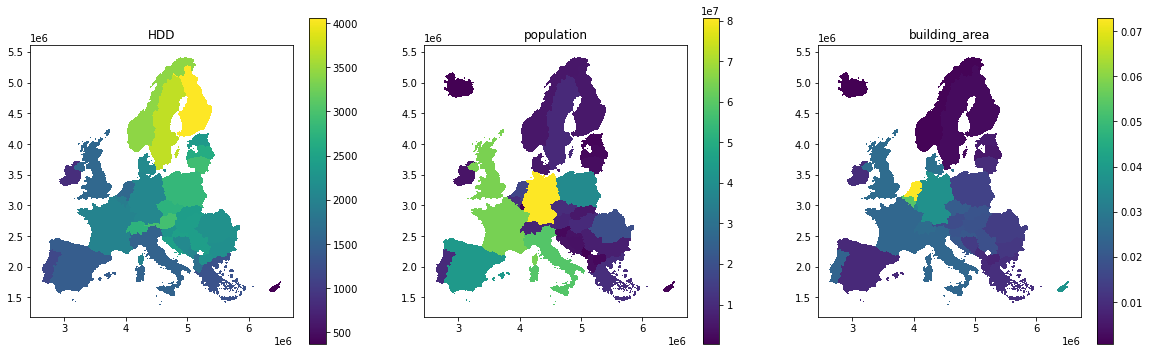

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
units_reshaped = national_units.to_crs('EPSG:3035')
units_reshaped.plot('hdd', antialiased=False, legend=True, ax=ax[0])
units_reshaped.plot('population', antialiased=False, legend=True, ax=ax[1])
units_reshaped.plot('building_area', antialiased=False, legend=True, ax=ax[2])
ax[0].set_title('HDD')
ax[1].set_title('population')
ax[2].set_title('building_area')

In [ ]:
# Going to do the analysis across all years, to increase available data
national_annual_demand_ratio = pd.read_csv("../build/annual_heat_demand.csv", index_col=[0, 1])
national_annual_demand = national_annual_demand_ratio.mul(national_units.set_index('country_code').population, level='country_code', axis=0)
national_data_df = national_annual_demand.assign(hdd=hdd_2.stack())
national_data_df['population'] = national_data_df.assign(population=1).population.mul(national_units.set_index('country_code').population, level='country_code')
national_data_df['building_area'] = national_data_df.assign(building_area=1).building_area.mul(national_units.set_index('country_code').building_area, level='country_code')

rmse: 12.225540511486
rmse: 0.5455197687101851
rmse: 1.3363246788994585


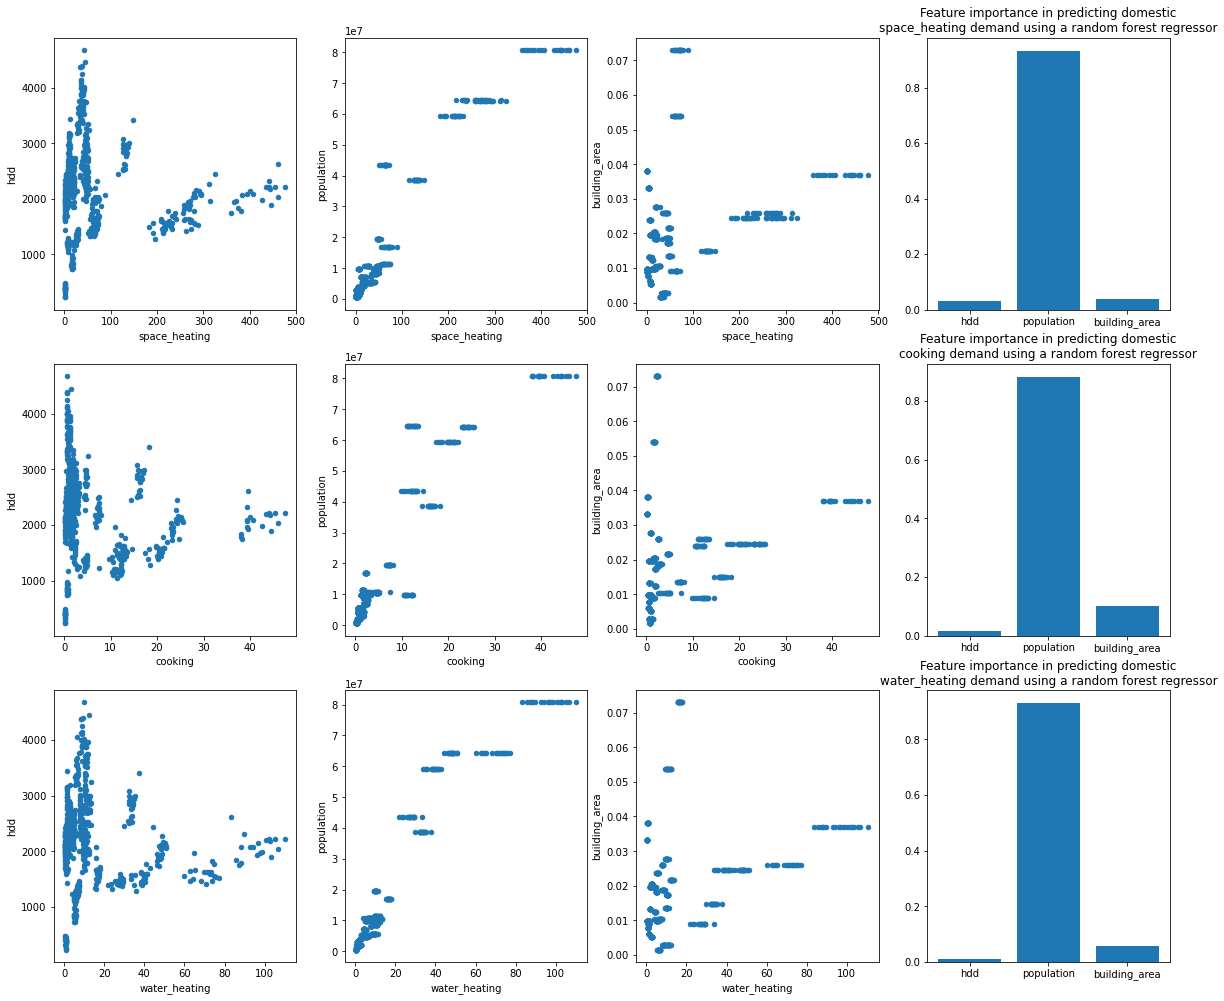

In [289]:
fig, ax = plt.subplots(3, 4, figsize=(20, 17))
_ax = 0
for i in ['space_heating', 'cooking', 'water_heating']:
    data = national_data_df.dropna().sample(frac=1)
    x_train, x_test, y_train, y_test = train_test_split(data[['hdd', 'population', 'building_area']].values, data[i].values, test_size=0.25, random_state=23)
    rand_forest_model = RandomForestRegressor(random_state=23)
    rand_forest_model.fit(x_train, y_train)
    y_pred = rand_forest_model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'rmse: {np.sqrt(mse)}')
    imp = rand_forest_model.feature_importances_
    
    pd.DataFrame(national_data_df).plot.scatter(x=i, y='hdd', ax=ax[_ax, 0])
    pd.DataFrame(national_data_df).plot.scatter(x=i, y='population', ax=ax[_ax, 1])
    pd.DataFrame(national_data_df).plot.scatter(x=i, y='building_area', ax=ax[_ax, 2])
    ax[_ax, 3].bar(x=['hdd', 'population', 'building_area'], height=imp)
    ax[_ax, 3].set_title(f'Feature importance in predicting domestic\n{i} demand using a random forest regressor')
    _ax += 1

In [68]:
heating_per_pop = national_data_df.space_heating / national_data_df.population

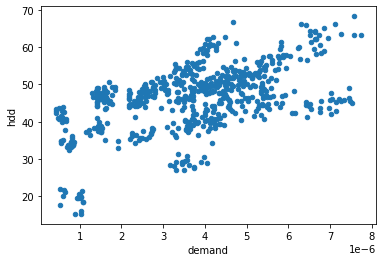

In [73]:
pd.concat([heating_per_pop, national_data_df.hdd.apply(np.sqrt)], keys=['demand', 'hdd'], axis=1).plot.scatter(x='demand', y='hdd')

In [80]:
import seaborn as sns

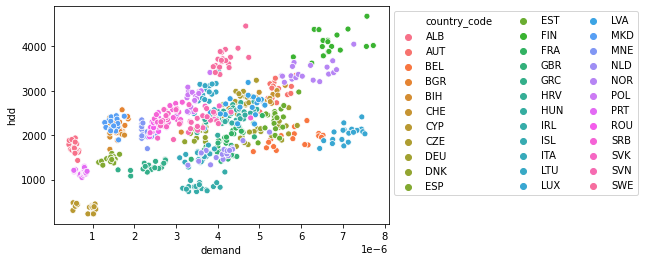

In [83]:
ax = sns.scatterplot(
    data=pd.concat([heating_per_pop, national_data_df.hdd], keys=['demand', 'hdd'], axis=1).reset_index(),
    x='demand', 
    y='hdd', 
    hue='country_code'
)
ax.legend(bbox_to_anchor=(1, 1), ncol=3)

In [104]:
pop = pd.read_csv('https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv', header=0)
def alpha3(x):
    try:
        return util.get_alpha3(x)
    except:
        return np.nan
pop['Location'] = pop['Location'].apply(alpha3)
pop = pop[pop.Variant=='Medium'].dropna(subset=['Location']).set_index(['Location', 'Time'])['PopTotal']

In [113]:
hdd

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
AUT,2755.736572,2994.426758,2795.746094,3182.668213,3155.828125,3281.138428,3104.469238,2770.629883,2827.919434,3058.724609,3342.433350,2837.093994,3048.148193,3097.696045,2524.116699,2728.869629,2910.683105,2938.918213,2733.598633
BEL,1779.372803,2038.424805,1788.378906,1982.926392,1997.910034,1952.312988,2030.358765,1656.666138,1920.919678,1989.232300,2328.166260,1715.540771,1965.116699,2191.765869,1629.757324,1743.207153,1985.140625,1908.630615,1840.968018
BGR,2160.760498,2268.538574,2184.163818,2571.051758,2217.790527,2345.472656,2296.090088,2051.822021,2063.614014,2125.695557,2084.818848,2365.536865,2420.835938,2041.812378,1883.523438,2120.534912,2052.334717,2219.690674,2084.059082
HRV,2293.464355,2552.393555,2364.115723,2686.018555,2613.452637,2733.728760,2562.825195,2265.146240,2327.890137,2439.151611,2572.717773,2487.224365,2541.070068,2458.713379,2058.031738,2384.038086,2352.453369,2471.547852,2353.313232
CYP,480.148102,307.724976,401.100494,440.479095,466.649353,379.819214,416.583405,389.917023,409.016754,338.406616,252.235138,333.724335,453.066681,378.872345,229.561295,385.804840,372.450378,391.071106,228.735275
CZE,2486.204834,2865.338867,2730.898193,2986.281006,2877.165283,2987.181152,2932.497559,2500.239014,2530.275635,2759.415527,3235.210205,2703.173096,2852.832275,2870.515869,2266.858154,2474.646973,2702.837646,2730.779785,2468.535400
DNK,1932.070312,2325.641113,2114.065430,2207.155518,2132.081543,2100.719727,2186.006592,1851.127808,1946.494507,2087.847168,2685.372803,2094.332275,2213.422363,2310.025391,1864.683472,1852.119873,2129.699951,2037.656982,2144.120605
EST,1993.861694,2588.764404,2432.154785,2529.478027,2428.017578,2455.125732,2477.991699,2180.942871,1933.339966,2410.216553,2971.019287,2323.125488,2665.982422,2485.221924,2164.020996,1826.875977,2263.429443,2144.230957,2391.863281
FIN,3759.152100,4380.212402,4374.043457,4134.720703,4130.969727,3993.016846,4101.916016,3877.070312,3784.152588,4252.323730,4674.827637,3874.246826,4387.099609,3995.957275,3883.308594,3620.545410,3913.598145,4016.888916,3996.137207
FRA,1943.176147,2051.157959,1820.182129,2105.921875,2144.585938,2159.071777,2029.657837,1882.900879,2061.586914,2093.892090,2441.839111,1746.346802,2088.961914,2269.146240,1737.694092,1866.758667,2033.255981,1956.640259,1879.334351


In [112]:
hdd_2

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
PRT,3204.875488,3538.723145,3269.689209,3546.333740,3639.518555,3769.125977,3556.519043,3265.969238,3324.080078,3465.714600,3852.711426,3237.903076,3462.176270,3577.462402,2987.899902,3162.975586,3302.661621,3380.244385,3094.921387
ESP,2158.268066,2415.563721,2212.420410,2448.194092,2416.621338,2306.734131,2300.565674,2068.388428,2350.372070,2371.169678,2848.267578,2084.809082,2399.557861,2628.369141,1958.368652,2238.674805,2359.971680,2211.252197,2134.056396
DNK,2290.286621,2341.570557,2296.270264,2680.113770,2278.907471,2471.499023,2404.069824,2126.842773,2188.547363,2198.971436,2242.588135,2524.241211,2424.213623,2090.415039,2026.047119,2207.710205,2208.642578,2305.359863,2103.198730
NOR,1833.883911,2113.353271,1960.390137,2323.617188,2195.076172,2360.371582,2150.281738,1918.325317,1935.523071,2036.343262,2271.068115,2107.196533,2127.733154,2046.977905,1665.912598,1988.677124,1986.687500,2049.143799,1885.898071
ITA,339.582520,203.578842,276.119202,310.561951,354.615906,270.678131,286.604736,258.473633,286.419678,209.154922,148.762650,219.454361,315.388275,245.613022,127.898254,266.856567,248.979782,268.254730,122.108139
FRA,2781.891357,3230.359131,3022.672852,3216.430176,3169.308594,3283.485596,3196.682129,2801.014404,2851.200439,3005.273682,3585.134033,2934.909668,3114.888428,3198.670166,2528.173584,2745.823975,2916.372070,3004.339111,2691.359863
CHE,2401.334473,2795.972900,2593.530029,2719.221436,2649.456787,2564.978027,2528.836182,2349.736572,2376.489746,2613.466553,3288.230225,2551.850586,2768.433838,2750.535400,2203.204590,2413.793457,2514.081055,2425.221191,2464.895996
DEU,3448.573975,4012.113037,3942.260742,4074.035645,3926.191650,3833.164551,3761.293701,3567.424072,3347.604980,3866.241455,4441.419434,3621.747070,4094.784668,3756.696777,3614.158691,3253.149902,3631.691162,3648.965576,3611.926025
AUT,4780.252930,5303.985840,5279.714355,5136.053711,5113.318359,4900.679199,4984.416992,4860.532715,4881.955566,5218.480469,5670.088867,4749.226562,5411.521484,4850.273926,4844.104004,4590.442871,4835.917480,5053.617676,4881.322754
ISL,1981.317505,2137.913330,1872.712891,2111.325928,2173.208740,2195.808105,2048.488281,1953.113037,2147.826416,2116.081787,2500.874268,1780.566650,2135.800049,2314.862305,1766.473389,1911.213501,2050.367188,1998.432617,1885.731934


In [101]:
national_data_df['hdd'].merge(pop, left_on=['country_code', 'year'], right_on=['Location', 'Time'])

AttributeError: 'Series' object has no attribute 'merge'

In [114]:
national_data_df=national_data_df.assign(population_changing=pop.reindex(national_data_df.index))
national_data_df=national_data_df.assign(hdd_2=hdd_2.stack().reindex(national_data_df.index))

In [192]:
pd.concat([heating_per_pop, national_data_df.hdd], keys=['demand per pop', 'hdd (kozarcanin)'], axis=1).loc[idx[:, list(range(2010, 2019))], :]

demand per pop  hdd (kozarcanin)
country_code year                                  
ALB          2010    5.724032e-07       1647.458740
             2011    5.607912e-07       1729.044678
             2012    5.854586e-07       1844.251343
             2013    6.623617e-07       1618.771484
             2014    6.437977e-07       1431.938232
...                           ...               ...
SWE          2014    4.045024e-06       3529.655273
             2015    3.942611e-06       3409.656982
             2016    4.193206e-06       3678.728027
             2017    4.088142e-06       3683.926758
             2018    4.744528e-06       3749.924072

[315 rows x 2 columns]

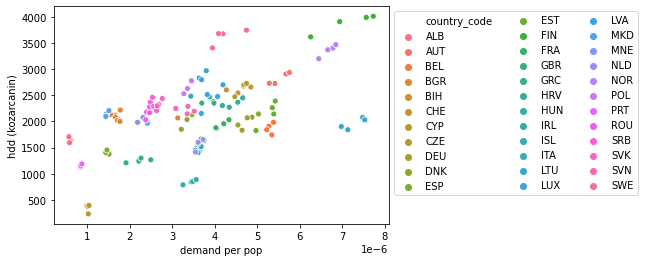

In [196]:
heating_per_pop = national_data_df.space_heating / national_data_df.population
ax = sns.scatterplot(
    data=pd.concat([heating_per_pop, national_data_df.hdd], keys=['demand per pop', 'hdd (kozarcanin)'], axis=1).loc[idx[:, list(range(2015, 2019))], :].reset_index(),
    x='demand per pop', 
    y='hdd (kozarcanin)', 
    hue='country_code'
)
ax.legend(bbox_to_anchor=(1, 1), ncol=3)

In [167]:
pd.concat([heating_per_pop, national_data_df.hdd], keys=['demand per pop', 'hdd (kozarcanin)'], axis=1).sort_values('hdd (kozarcanin)').dropna()

demand per pop  hdd (kozarcanin)
country_code year                                  
CYP          2018    1.021763e-06        228.735275
             2014    8.893925e-07        229.561295
             2010    1.023411e-06        252.235138
             2001    5.304000e-07        307.724976
             2011    1.076260e-06        333.724335
...                           ...               ...
FIN          2002    6.427570e-06       4374.043457
             2001    6.313593e-06       4380.212402
             2012    7.123532e-06       4387.099609
SWE          2010    4.672269e-06       4454.805176
FIN          2010    7.577758e-06       4674.827637

[646 rows x 2 columns]

In [169]:
national_data_df.xs('BEL')

,commercial_space_heating,commercial_water_heating,cooking,space_heating,water_heating,hdd,population,building_area,population_changing,hdd_2
year,,,,,,,,,,
2000,21.858330,3.346661,1.751342,69.631781,11.637112,1779.372803,1.129256e+07,0.053849,10282.046,2310.358398
2001,23.249595,3.276074,1.823883,72.515920,12.119120,2038.424805,1.129256e+07,0.053849,10319.026,2488.045410
2002,24.825805,3.782520,1.729063,68.745996,11.489077,1788.378906,1.129256e+07,0.053849,10364.879,2348.640869
2003,26.822229,3.818884,1.823956,72.518852,12.119610,1982.926392,1.129256e+07,0.053849,10419.029,2763.814941
2004,27.572127,3.977948,1.853162,73.680049,12.313673,1997.910034,1.129256e+07,0.053849,10480.118,2531.289795
2005,27.471612,3.844265,1.842754,73.266251,12.244518,1952.312988,1.129256e+07,0.053849,10546.885,2754.298584
2006,25.998949,3.774247,1.657622,65.905569,11.014374,2030.358765,1.129256e+07,0.053849,10619.484,2562.098633
2007,21.536088,3.533406,1.535105,61.034404,10.200288,1656.666138,1.129256e+07,0.053849,10697.576,2293.444092
2008,26.913289,4.000144,1.647759,65.513427,10.948838,1920.919678,1.129256e+07,0.053849,10778.764,2299.739014


In [179]:
national_data_df.xs('LUX')

,commercial_space_heating,commercial_water_heating,cooking,space_heating,water_heating,hdd,population,building_area,population_changing,hdd_2
year,,,,,,,,,,
2000,2.059400,0.315308,0.130976,3.692745,0.318391,1875.800415,564576.395232,0.033166,436.106,5559.347656
2001,1.916386,0.270036,0.140882,3.972030,0.342472,2119.165283,564576.395232,0.033166,440.197,5431.150391
2002,2.008537,0.306026,0.135318,3.815156,0.328946,1902.886719,564576.395232,0.033166,443.727,5300.116211
2003,2.384781,0.339539,0.140265,3.954624,0.340971,2110.593750,564576.395232,0.033166,447.317,5065.248535
2004,2.268005,0.327215,0.149104,4.203841,0.362459,2136.279785,564576.395232,0.033166,451.822,5226.513184
2005,2.134565,0.298702,0.146961,4.143418,0.357249,2108.774414,564576.395232,0.033166,457.848,5488.725586
2006,2.116866,0.307304,0.144421,4.071806,0.351074,2135.139893,564576.395232,0.033166,465.611,5308.972656
2007,1.849833,0.303500,0.140644,3.965319,0.341893,1758.455933,564576.395232,0.033166,474.917,5366.647461
2008,2.078617,0.308946,0.143036,4.032749,0.347707,2045.032227,564576.395232,0.033166,485.403,5471.336426


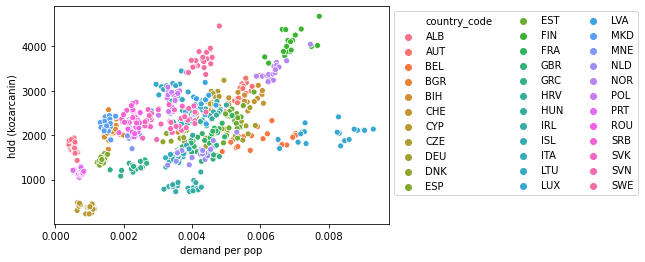

In [118]:
heating_per_pop = national_data_df.space_heating / national_data_df.population_changing
ax = sns.scatterplot(
    data=pd.concat([heating_per_pop, national_data_df.hdd], keys=['demand per pop', 'hdd (kozarcanin)'], axis=1).reset_index(),
    x='demand per pop', 
    y='hdd (kozarcanin)', 
    hue='country_code'
)
ax.legend(bbox_to_anchor=(1, 1), ncol=3)

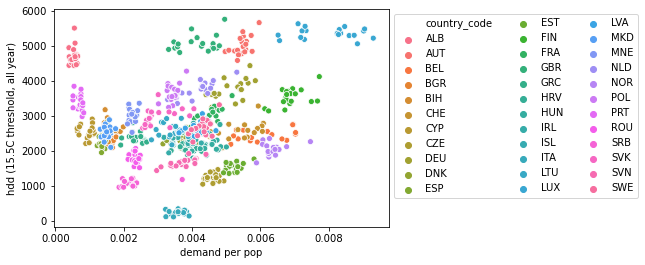

In [120]:
heating_per_pop = national_data_df.space_heating / national_data_df.population_changing
ax = sns.scatterplot(
    data=pd.concat([heating_per_pop, national_data_df.hdd_2], keys=['demand per pop', 'hdd (15.5C threshold, all year)'], axis=1).reset_index(),
    x='demand per pop', 
    y='hdd (15.5C threshold, all year)', 
    hue='country_code'
)
ax.legend(bbox_to_anchor=(1, 1), ncol=3)

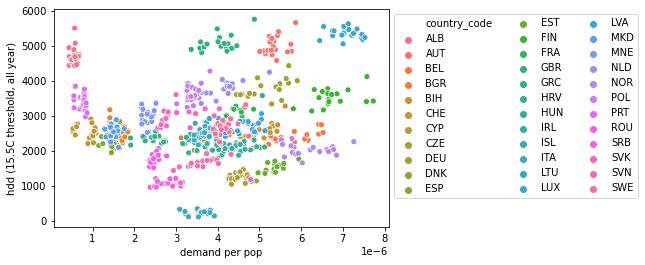

In [121]:
heating_per_pop = national_data_df.space_heating / national_data_df.population
ax = sns.scatterplot(
    data=pd.concat([heating_per_pop, national_data_df.hdd_2], keys=['demand per pop', 'hdd (15.5C threshold, all year)'], axis=1).reset_index(),
    x='demand per pop', 
    y='hdd (15.5C threshold, all year)', 
    hue='country_code'
)
ax.legend(bbox_to_anchor=(1, 1), ncol=3)

In [125]:
national_data_df.index.levels[1]

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='year')

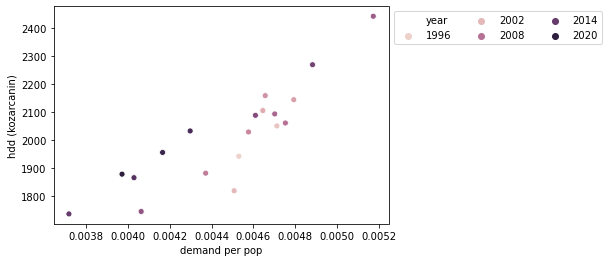

In [137]:
heating_per_pop = national_data_df.space_heating / national_data_df.population_changing
ax = sns.scatterplot(
    data=pd.concat([heating_per_pop, national_data_df.hdd], keys=['demand per pop', 'hdd (kozarcanin)'], axis=1).xs('FRA').reset_index(),
    x='demand per pop', 
    y='hdd (kozarcanin)', 
    hue='year'
)
ax.legend(bbox_to_anchor=(1, 1), ncol=3)

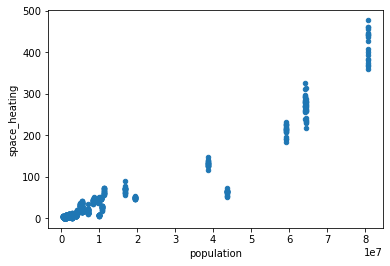

In [142]:
national_data_df.plot.scatter('population', 'space_heating')

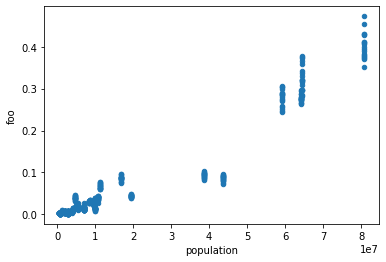

In [159]:
national_data_df.assign(foo=(national_data_df.space_heating / (national_data_df.hdd ** 1/2) )).plot.scatter('population', 'foo')

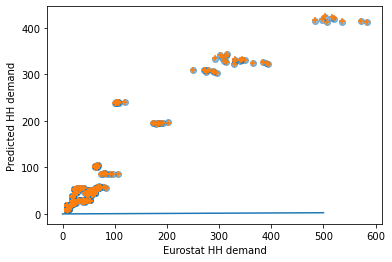

In [273]:
heating_per_pop = national_data_df[['space_heating', 'water_heating', 'cooking']].sum(axis=1) / (national_data_df.population / 1e6)
foo = national_data_df.assign(demand=national_data_df.dropna()[['space_heating', 'water_heating', 'cooking']].sum(axis=1)).dropna().loc[idx[:, list(range(2010, 2019))], :].dropna().drop(
    ['ALB', 'CYP', 'LUX', 'MKD', 'MNE'], level=0
)
foo.population = foo.population_changing
model1 = sm.OLS(foo.demand, foo[['hdd', 'population']])
model2 = sm.OLS(foo.demand, foo.population)
res1 = model1.fit()
res2 = model2.fit()
#ax = foo.plot.scatter('demand', 'hdd (kozarcanin)', c='black', alpha=0.4)
fig, ax = plt.subplots(1, 1)
ax.scatter(foo.demand, res1.predict(foo[['hdd', 'population']]), alpha=0.5, marker='o')
ax.scatter(foo.demand, res2.predict(foo.population), marker='+')
ax.set_xlabel('Eurostat HH demand')
ax.set_ylabel('Predicted HH demand')
ax.plot([0, 500], res2.predict([0, 500]), markersize=0)

In [274]:
foo.population

country_code  year
AUT           2010    8409.945
              2011    8453.501
              2012    8502.230
              2013    8556.191
              2014    8615.205
                        ...   
SWE           2014    9692.137
              2015    9764.949
              2016    9836.003
              2017    9904.895
              2018    9971.630
Name: population, Length: 261, dtype: float64

In [242]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              4969.
Date:                Fri, 21 Aug 2020   Prob (F-statistic):                        0.00
Time:                        15:01:40   Log-Likelihood:                         -3226.8
No. Observations:                 646   AIC:                                      6458.
Df Residuals:                     644   BIC:                                      6466.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hdd           -0.0007      0.001     -1.049      0.295      -0.002       0.001
population   5.38e-06   6.25e-08     86.089      0.000    5.26e-06     5.5e-06
==============================================================================
Omnibus:                      136.688   Durbin-Watson:                   0.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2885.373
Skew:                           0.299   Prob(JB):                         0.00
Kurtosis:                      13.336   Cond. No.                     1.31e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

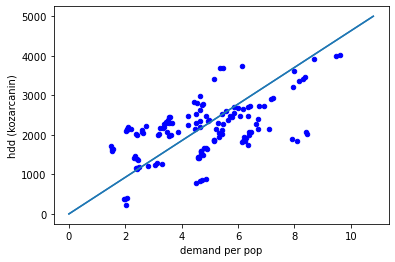

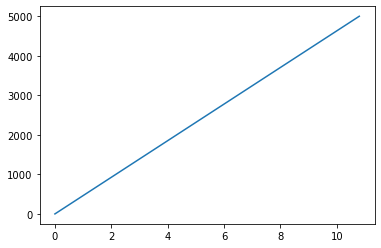

In [225]:
plt.plot(res.predict([i*500 for i in range(11)]), [i*500 for i in range(11)], markersize=0)[0]